## Imports etc.

In [1]:
import os
import shutil
import json
import re
import os
import datetime
from itertools import permutations 
import numpy as np
import time
from matplotlib import pyplot as plt
from google.colab import drive
import imageio
import glob
from PIL import Image
from functools import reduce
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import itertools
import pickle
import random
import os.path as path
from itertools import count

!pip install transformers
from transformers import *
import transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration
t5_model = 't5-small'


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
from torch import autograd
import torchvision

# imports the torch_xla package
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py 
# import torch_xla
# import torch_xla.core.xla_model as xm
# dev = xm.xla_device()

drive.mount('/content/drive')
root = "/content/drive/My Drive/School/CS601R/final project/"
print(root)

     |████████████████████████████████| 573kB 3.4MB/s 
     |████████████████████████████████| 890kB 16.1MB/s 
     |████████████████████████████████| 3.7MB 21.4MB/s 
     |████████████████████████████████| 1.0MB 29.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=3fe013e0118968429cfba6e7b024e49dcee328983e56ab027db3a63a00ca73a5
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your 

## Data Processing

### SMS dataset

In [0]:
with open(root + 'data/the-national-university-of-singapore-sms-corpus/smsCorpus_en_2015.03.09_all.json') as f:
  data = json.load(f)

In [0]:
nsamples = 10
for _ in range(nsamples):
    i = random.randint(0, len(data['smsCorpus']['message']))
    print(f'{i}:', data['smsCorpus']['message'][i]['text']['$'])

print("\nClearly this dataset isn't going to work.")

17235: Yar abid se bol wo presentatins wala page ka pta kre..wo chahia hai lazmi
36335: Yosh, we at makan place.
12774: Thank you princess!
15335: Sir, I am on the way  <#> min.
20934: Sounds great man thanks!
19026: Did you start
807: Anything lor up 2 u... Dun buy anything too expensive...
36104: Haha, kk I now go bathe.
46796: LOL OMG HAHAHA HOW DID HE BUT THEM HAHAHA OWNED!!!!!
3506: pls dun b like tat!

Clearly this dataset isn't going to work.


### Movie Scripts

In [0]:
!ls "/content/drive/My Drive/School/CS601R/final project/data/cornell movie-dialogs corpus"

chameleons.pdf		       movie_lines.txt		  README.txt
movie_characters_metadata.txt  movie_titles_metadata.txt
movie_conversations.txt        raw_script_urls.txt


In [0]:
lines = pd.read_csv(root + 'data/cornell movie-dialogs corpus/movie_lines.txt', 
                    delimiter=' \+\+\+\$\+\+\+ ', engine='python', header=None, 
                    names=['lineID', 'characterID', 'movieID', 'character name', 'text'])
conversations = pd.read_table(root + 'data/cornell movie-dialogs corpus/movie_conversations.txt', 
                              delimiter=' \+\+\+\$\+\+\+ ', engine='python', header=None,
                              names = ['characterID1', 'characterID2', 'movieID', 'lineID list'])
titles = pd.read_table(root + 'data/cornell movie-dialogs corpus/movie_titles_metadata.txt',
                       delimiter=' \+\+\+\$\+\+\+ ', engine='python', header=None, 
                       names=['movieID', 'movie title', 'movie year', 'IMDB rating', '# IMDB votes', 'applicable genres'])
characters = pd.read_table(root + 'data/cornell movie-dialogs corpus/movie_characters_metadata.txt',
                       delimiter=' \+\+\+\$\+\+\+ ', engine='python', header=None, 
                       names=['characterID', 'character name', 'movieID', 'movie title', 'gender', 'position in credits'])

In [0]:
lines.sample(5)

,lineID,characterID,movieID,character name,text
41463,L267386,u1245,m82,SHUTTLE,He said one other thing. It wasn't very nice.
16129,L88190,u532,m34,DECKARD,Yeah.
39764,L255781,u1210,m79,LILLY,"Roy, I don't want money from you."
66123,L386811,u1934,m126,WITWER,"Wally, the other two can still function, right?"
2508,L6169,u84,m5,KORBEN,"Yeah, I know... to save the world... but right..."


In [0]:
conversations.sample(5)

,characterID1,characterID2,movieID,lineID list
19557,u2127,u2129,m138,"['L391687', 'L391688', 'L391689']"
70116,u7633,u7635,m516,"['L508796', 'L508797']"
41196,u4393,u4398,m291,"['L124211', 'L124212', 'L124213']"
28166,u3043,u3050,m199,"['L542997', 'L542998']"
28057,u3033,u3037,m198,"['L540543', 'L540544']"


In [0]:
titles.sample(5)

,movieID,movie title,movie year,IMDB rating,# IMDB votes,applicable genres
416,m416,kramer vs. kramer,1979,7.7,25836,['drama']
552,m552,the limey,1999,7.0,15465,"['crime', 'drama', 'mystery', 'thriller']"
14,m14,alien nation,1988,6.1,5590,"['crime', 'drama', 'sci-fi', 'thriller']"
433,m433,the matrix,1999,8.7,389480,"['action', 'adventure', 'adventure', 'adventur..."
64,m64,friday the 13th,2009,5.6,27499,['horror']


In [0]:
characters.sample(5)

,characterID,character name,movieID,movie title,gender,position in credits
6963,u6963,MUTT,m465,on the waterfront,?,?
4327,u4327,SANDY,m288,bull durham,?,?
7002,u7002,DORIE,m468,pearl harbor,?,?
8894,u8894,GINGER,m605,who's your daddy?,f,?
6225,u6225,SECRETARY,m416,kramer vs. kramer,?,?


In [0]:
def f(X):
    return [lines[lines.lineID==x].text.values for x in X.split('\'')[1::2]]

conversations['convo'] = conversations['lineID list'][:4].apply(f)
conversations

,characterID1,characterID2,movieID,lineID list,convo
0,u0,u2,m0,"['L194', 'L195', 'L196', 'L197']",[[Can we make this quick? Roxanne Korrine and...
1,u0,u2,m0,"['L198', 'L199']",[[You're asking me out. That's so cute. What'...
2,u0,u2,m0,"['L200', 'L201', 'L202', 'L203']","[[No, no, it's my fault -- we didn't have a pr..."
3,u0,u2,m0,"['L204', 'L205', 'L206']","[[Why?], [Unsolved mystery. She used to be re..."
4,u0,u2,m0,"['L207', 'L208']",NaN
...,...,...,...,...,...
83092,u9028,u9031,m616,"['L666324', 'L666325', 'L666326', 'L666327']",NaN
83093,u9028,u9031,m616,"['L666575', 'L666576']",NaN
83094,u9030,u9034,m616,"['L666256', 'L666257']",NaN
83095,u9030,u9034,m616,"['L666369', 'L666370', 'L666371', 'L666372']",NaN


In [0]:
conversations['convo'] = conversations['lineID list'].apply(f)
conversations.to_pickle(root+"data/movie_convos.pkl")

NameError: ignored

#### Dataset

In [0]:
class MovieDataset(Dataset):

    def __init__(self, root=rootCody):
        super(MovieDataset, self).__init__()

        self.df = pd.read_pickle(root+"data/wiki.pkl")

    def __get_item__(self, i):

        # TODO, How do we want to load the data? should we load it in 

        return df.iloc[i]


    def __len__(self):
        return len(self.df)

### Wikipedia Conversations

#### Construct pickle

In [0]:
!git clone https://github.com/facebookresearch/ParlAI.git ~/ParlAI
!cd ~/ParlAI; python3 setup.py develop
!python ~/ParlAI/examples/display_data.py -t wizard_of_wikipedia

In [0]:
def extract_convos():
    """
    get wiki files and parse conversations
    """
    df = pd.read_json("/root/ParlAI/data/wizard_of_wikipedia/train.json")

    def f(x):
        return [x[i]['text'] for i in range(len(x))]

    def g(x):
        return [x[i]['speaker'] for i in range(len(x))]

    df['convo'] = df.dialog.apply(f)
    df["convo_len"] = df.convo.apply(len)
    df['speakers'] = df.dialog.apply(g)
    df.to_pickle(root+"data/wiki.pkl")
    return df

df = extract_convos()
df.convo[1], df.convo_len[1], df.speakers[1]

(['Can you imagine the world without internet access? ',
  "No I could not! I couldn't imagine living when internet access was rare and very few people had it!",
  'Oh me either! It seems like such a long time ago. I wonder when Internet was first created?',
  'It used to be restricted, but around 1995, the restricted were lifted and commercial use of it began',
  'That is awesome. I wonder why it was restricted? Probably because they only wanted government and big companies to use it at first.',
  'Yes, it was developed from a government funded projects to help with universities research and laboratories in the United States...I am so glad they expanded it! ',
  'I am too, it makes life so much easier!',
  'What is your favorite thing to do with internet access? I like being able to use my computer and smartphone to use my email and browse the world wide web'],
 8,
 ['0_Apprentice',
  '1_Wizard',
  '0_Apprentice',
  '1_Wizard',
  '0_Apprentice',
  '1_Wizard',
  '0_Apprentice',
  '1_Wi

In [0]:
df = pd.read_pickle(root+"data/wiki.pkl")
df.sample(5)

,chosen_topic,persona,wizard_eval,dialog,chosen_topic_passage,convo,convo_len,speakers
17684,NASCAR,i race cars for a living.,5,"[{'speaker': '0_Apprentice', 'text': 'Have you...",[The National Association for Stock Car Auto R...,[Have you ever watched NASCAR? I always hear a...,8,"[0_Apprentice, 1_Wizard, 0_Apprentice, 1_Wizar..."
13975,Guitar,i play the guitar.,5,"[{'speaker': '0_Apprentice', 'text': 'I have a...",[The guitar is a fretted musical instrument th...,[I have always wanted to learn to play the gui...,8,"[0_Apprentice, 1_Wizard, 0_Apprentice, 1_Wizar..."
13211,Cruise ship,i have never been on a cruise ship.,5,"[{'speaker': '0_Wizard', 'text': 'Do you know ...",[A cruise ship or cruise liner is a passenger ...,[Do you know that a cruise ship is a passenge...,8,"[0_Wizard, 1_Apprentice, 0_Wizard, 1_Apprentic..."
14450,Vermont,i live in vermont.,5,"[{'speaker': '0_Wizard', 'text': 'Hi, my wife ...",[Vermont () is a state in the New England regi...,"[Hi, my wife is from Vermont, a state in the N...",8,"[0_Wizard, 1_Apprentice, 0_Wizard, 1_Apprentic..."
14166,Rose,my favorite flower is a rose.,4,"[{'speaker': '0_Wizard', 'text': 'My favorite ...",[A rose is a woody perennial flowering plant o...,[My favorite flower is rose and i have ten out...,8,"[0_Wizard, 1_Apprentice, 0_Wizard, 1_Apprentic..."


In [0]:
df['convo_len'].values

array([10,  8, 10, ...,  8,  8, 10])

In [0]:

for i in range(10):
    total = ""
    sample = df.sample(1)

    val = f""
    val += f"topic: {sample['chosen_topic'].values[0]}"
    for i in range(sample['convo_len'].values[0]):
        speaker = sample['speakers'].values[0][i]
        text = sample['convo'].values[0][i]
        
        val += f'  {speaker}: {text}'

    total = val + "\n"
    print(val)


open(root+"data/test.txt","w+").write(total)
s = set(total.split())
open(root+"data/test_vocab.txt","w+").write("\n".join(s))

topic: Obesity in the United States  0_Wizard: obestiy in the US has gotten worse in reent decades  1_Apprentice: Yes it has. I personally blame the fast food industry - tons of cheap food laden with fat and sugar!  0_Wizard: yea and its a major health issue as it has resulted in diseases such as coronary heart diseas that leads to mortality  1_Apprentice: It's absolutely awful. The Government needs to do something - people's lives are at risk. Any idea how to reverse this trend?  0_Wizard: nothing concrete but the overweight percentages for the US population are higher reaching 39.4% in 1997, 44.5% in 2004 and 56.6% in 2007  1_Apprentice: That's a heck of a hike! What other information do you have about this epidemic?  0_Wizard: well its expected that the number is suspeted to increaste to about $1.24 billion by 2030 for added medical expenses  1_Apprentice: I bet the insurance companies are loving that! If it's going to cost so much, surely it's worth the government's time to address

794

In [0]:
# ds = tx.data.TextLineDataSource(root+"data/test.txt")
# dl = tx.data.MonoTextData(ds)
# dl[0]

hparams = {'dataset': { 'files': root+"data/test.txt", 'vocab_file': root+"data/test_vocab.txt"},
           'batch_size': 1}
data = tx.data.MonoTextData(hparams)
iterator = tx.data.DataIterator(data)
for batch in iterator:
    print(batch)

{'text': [['<BOS>', 'topic:', 'Amateur', 'geology', '0_Apprentice:', 'Hi,', "I'm", 'into', 'amateur', 'geology', 'which', 'includes', 'stuff', 'like', 'macaroni', 'art.', 'Have', 'you', 'ever', 'tried', 'amateur', 'geology?', '1_Wizard:', 'Yes', 'I', 'have,', 'I', 'have', 'been', 'an', 'Amateur', 'geologist', 'for', '5', 'years', 'now', 'and', 'I', 'am', 'still', 'studying', 'in', 'the', 'field.', 'Maybe', 'we', 'could', 'share', 'what', 'we', 'know,', 'Is', 'there', 'anything', 'your', 'curious', 'about', 'in', 'geology?', '0_Apprentice:', 'I', 'think', 'I', 'am', 'very', 'curious', 'about', 'the', 'possibility', 'for', 'undiscovered', 'rocks', 'and', 'mineral', 'specimens.', 'Also', 'in', 'rare', 'specimens.', '1_Wizard:', 'Indeed,', 'I', 'usually', 'do', 'it', 'for', 'the', 'recreational', 'study', 'and', 'hobby', 'of', 'collecting', 'rocks', 'and', 'mineral', 'specimens,', 'Usually', 'from', 'their', 'natural', 'environment.', '0_Apprentice:', 'I', 'also', 'think', 'that', 'we', 'c

In [0]:
# df = pd.read_pickle(root+"data/wiki.pkl")
df.dialog[0][1]['speaker']

NameError: ignored

#### Dataset

In [0]:
class WikiDataset(Dataset):
    def __init__(self, root=root, reset_length=0, max_epoch_length=None, tokenizer=T5Tokenizer.from_pretrained('t5-small')):
        super(WikiDataset, self).__init__()

        df = pd.read_pickle(root+"data/wiki.pkl").sample(frac=1)
        self.df = df

        self.full_length = len(df)
        self.max_epoch_length = max_epoch_length     # this will allow us to set shorter epochs to introduce more randomness into the length
        self.length =  self.full_length
        self.reset_length = reset_length

        # store data as arrays instead of dataframe
        self.conv_lengths = df['convo_len'].values
        self.conversations = df['convo'].values
        self.speakers = df['speakers'].values
        self.topics = df['chosen_topic'].values

        self.n_lines_used = np.ones(self.full_length).astype(int)
        self.last_line_reached_bool = np.zeros(self.full_length).astype(int)

        # set tokenizer
        # take a look at t5 toeknizer 
        self.tokenizer = tokenizer
        tokens = ['topic', '0_Wizard','1_Apprentice']
        self.tokenizer.add_tokens(tokens)

        self.temp_last_line_reached_bool = np.zeros(self.full_length).astype(int)
        

    def __getitem__(self, i):
        # determine shifted index
        i += np.sum(self.last_line_reached_bool[:i+1]) # this could exceed total length if update_at_end_of_epoch isn't called correctly
        i = i.astype(int)

        if i >= self.full_length:
            raise IndexError("WikiDataset.update_at_end_of_epoch must be called only at the end of each epoch for expended lines to be tracked properly.")
        if self.n_lines_used[i] >= self.conv_lengths[i] - 1:
            raise IndexError("WikiDataset.update_at_end_of_epoch must be called at the end of each epoch for expended lines to be tracked properly.")

        # determine how long to include (currently fixed at one more line than the last time)
        lines_to_include = self.n_lines_used[i] + 1

        # update number of lines used
        self.n_lines_used[i] = lines_to_include

        # if used whole string decrement length by 1 and add index to list of exceptions
        if lines_to_include  >= self.conv_lengths[i] - 1:
            self.length -= 1
            self.temp_last_line_reached_bool[i] = 1

        # construct string to be fed to generator/discriminator
        common_prompt = ''
        true_response = ''

        common_prompt += f'topic: {self.topics[i]}'
        for j in range(lines_to_include):
            speaker = self.speakers[i][j]
            text = self.conversations[i][j]
            
            if j == lines_to_include - 1:
                common_prompt += f'  {speaker}: '
                true_response = text
            else:
                common_prompt += f'  {speaker}: {text}'

        if self.tokenizer:
            common_prompt = self.tokenizer.encode(common_prompt, return_tensors="pt") 
            true_response = self.tokenizer.encode(true_response, return_tensors="pt")

        return common_prompt.squeeze(0), true_response.squeeze(0)

    def __len__(self):
        # if reached minimum tolerable length raise warning and reset
        if self.length <= self.reset_length:
            warnings.warn('Reset length reached. Dataloader reset. The model may begin to overfit the data in a critical manner.')
            self.reset()

        if self.max_epoch_length:
            return min(self.length, self.max_epoch_length)
        else:
            return self.length

    def decode(self, id_list):
        return self.tokenizer.convert_tokens_to_string(dataset.tokenizer.convert_ids_to_tokens(id_list))

    def encode(self, str):
        return self.tokenizer.encode(str)

    def reset(self):
        self.length =  self.full_length
        self.n_lines_used = np.zeros(self.full_length).astype(int)
        self.last_line_reached_bool = np.zeros(self.full_length).astype(int)
        self.temp_last_line_reached_bool = np.zeros(self.full_length).astype(int)

    def update_at_end_of_epoch(self):
        self.last_line_reached_bool = np.copy(self.temp_last_line_reached_bool)

In [0]:
dataset = WikiDataset()#tokenizer=None)

In [0]:
discriminator_decoder = {632: 0.0, 209: .1, 204: .2, 220: .3, 314: .4, 305: .5, 431: .6, 489: .7, 505: .8, 668: .9, 335: 1.0}

for i in range(11):
    print(i, dataset.encode(str(np.round(i, 2))))

0 [3, 632]
1 [209]
2 [204]
3 [220]
4 [314]
5 [305]
6 [431]
7 [489]
8 [505]
9 [668]
10 [335]


In [0]:
dataset.decode([632])

'0'

## Playground 1

In [0]:
# Adding layers possibly??? Not sure it will effect the foward method, 
dataset = WikiDataset()
dataloader = DataLoader(dataset, batch_size=1)

disc = T5ForConditionalGeneration.from_pretrained('t5-small')
disc.resize_token_embeddings(len(dataset.tokenizer))
print(len(disc.get_output_embeddings()))

# doesnt seem to work
# new_disc = nn.Sequential(disc, nn.Linear(512,2), nn.Softmax())

for prompt, true_response in dataloader:
    inp = torch.cat((prompt, true_response), 1)
    print(inp.size())
    out1, out2 = disc.forward(inp, decoder_input_ids=inp)
    # looks like it provides probabilities over the whole vocab?
    print(out1.size(), out2.size())
    # print(new_disc())
    break

#OR 

# disc.add_module("linear", nn.Linear(512,2))
# disc.add_module("softmax", nn.Softmax())
# len(list(disc.children()))

#? Not sure yet need to do more research

TypeError: ignored

In [0]:
testModel = transformers.T5Model.from_pretrained('t5-small')

In [0]:
# class t5Discriminator(nn.Module):
#     def __init__(self, baseModel=transformers.T5Model.from_pretrained('t5-small'), nclasses=2):
#         super(t5Discriminator, self).__init__()
#         self.baseModel = baseModel
#         self.baseModel.decoder_past_key_value_states = True
#         self.linear = nn.Linear(512, nclasses)
#         self.outf = nn.Softmax()

#     def forward(self, prompt, response):
#         x = self.baseModel(x, torch.tensor([]))
#         print(x.shape)
#         x = self.linear(x)
#         return self.outf(x)

In [0]:
dataset = WikiDataset()
dataloader = DataLoader(dataset, batch_size=1)

gen = T5ForConditionalGeneration.from_pretrained('t5-small')
gen.resize_token_embeddings(len(dataset.tokenizer))


disc = T5ForConditionalGeneration.from_pretrained('t5-small')
disc.resize_token_embeddings(len(dataset.tokenizer))

real_id = dataset.tokenizer.encode("real", return_tensors="pt")[0]
fake_id = dataset.tokenizer.encode("fake", return_tensors="pt")[0]
print("IDS")
print(real_id, fake_id)

real_label = torch.tensor([1.0]).unsqueeze(0)
fake_label = torch.tensor([0.0]).unsqueeze(0)


optimizerG = optim.Adam(gen.parameters(), lr=.001)#, betas=(beta1, 0.999))
optimizerD = optim.Adam(disc.parameters(), lr=.001)#, betas=(beta1, 0.999))


loss_func = nn.BCELoss()
real_label = torch.tensor([1.0]).unsqueeze(0)

for prompt, true_response in dataloader:
    print("Prompt decoded:", dataset.decode(prompt.squeeze(0)))
    print("Response decoded:", dataset.decode(true_response.squeeze(0)))

    out = gen.generate(prompt)#, max_length=true_response.size()[1])
    print("Output decoded:", dataset.decode(out.squeeze(0)))

    # disc_input = torch.cat((prompt, out), 1).unsqueeze(0).float()
    # out = disc.forward(inputs_embeds=disc_input)
    # print(out)

    disc_input = torch.cat((prompt, out), 1)
    disc_out = disc.generate(disc_input, max_length=1)
    print("disc Output decoded:", dataset.decode(disc_out.squeeze(0)))

    # THIS COULD BE A WAY WE DO IT? IF IT DOESNT OUTPUT THE WORD "true" WE CALL IT WRONG??
    if disc_out.item() == real_id:
        loss = loss_func(real_label, real_label)
    else:
        loss = loss_func(real_label, fake_label)

    loss.requires_grad = True
    print("Loss", loss)
    loss.backward()

    optimizerD.step()

    # print("Disc out:", disc_out)
    # print("Decoded disc out:", dataset.decode(disc_out.squeeze(0)))
    
    break

IDS
tensor([490]) tensor([9901])
Prompt decoded: topic: Spaghetti with meatballs 0_Apprentice: I like to have Spaghetti with meatballs for dinner. 1_Wizard:
Response decoded: I enjoy spaghetti as well. I believe the Italians started the trend
Output decoded: Spaghetti with meatballs 0_Apprentice: I like to have Sp
Desc Output decoded: topic: Spaghetti with meat: Spaghetti with meatballs 0_App


ValueError: ignored

In [0]:
# TESTING STUFF OUT

dataset.tokenizer.add_tokens()
#get data
#inp, disc_inp = dataset[4]
# prompt, true_response = dataset[4]
# print(dataset.tokenizer.decode(prompt.squeeze().numpy()))

# # run training for encoder - decoder 
# print("Training:")
# outputs = model(input_ids=prompt, decoder_input_ids=prompt)
# loss, prediction_scores = outputs[:2]

# print("loss", loss, "sdfsdf\n")
# print(prediction_scores.argmax(axis=2))

# output = prediction_scores.argmax(axis=2)
# for out in output:
#     print(dataset.tokenizer.decode(out.numpy()))

# Generate output depending on task
print()
outputs = model.generate(prompt, max_length=20)
print(outputs)
print(outputs.size())
print(dataset.decode(out))


tensor([[    0, 32099,    10,  5088,     7,    33,   310,  1134,     5,   363,
            66,  4217,    13,  4659,     7,   103,    25,   114,     8,   200]])
torch.Size([1, 20])
<extra_id_0>: Roses are really pretty. What all kinds of roses do you like the best


In [0]:
for out in outputs:
    print(dataset.tokenizer.decode(out))

New York City 0_Apprentice: New York is my favourite city in the world. 1_Wizard: Me too,I'm a new yorker! New York is the most populous city in the United States.


In [0]:
discriminator_loss_log_probabilities(np.zeros_like(outputs), outputs)

TypeError: ignored

In [0]:
def train_gan(epochs=1, gen_disc_ratio=3):
    
    # models
    gen = T5ForConditionalGeneration.from_pretrained('t5-small')
    disc = T5ForConditionalGeneration.from_pretrained('t5-small')

    gen.resize_token_embeddings(len(dataset.tokenizer))
    disc.resize_token_embeddings(len(dataset.tokenizer))

    # Setup Adam optimizers for both G and D
    optimizerG = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerD = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))

    # loss
    loss_func = nn.BCELoss()

    # yes no classifying labels
    real_label = torch.tensor([1.0]).unsqueeze(0)
    fake_label = torch.tensor([0.0]).unsqueeze(0)

    for e in epochs:

        for i, (prompt, response) in enumerate(dataset):

            gen_input = prompt
            true_input = torch.cat((prompt, response),1)

            # ------------------ TRAIN DISC ON TRUTH ------------------
            disc.zero_grad()

            #TODO Figure out how to CLASSIFY
            output = disc(true_input).view(-1)

            # Calculate loss on real conversation
            disc_real_loss = loss_func(output, real_label)

            # Calculate gradients for D in backward pass
            disc_real_loss.backward()

            # ------------------ TRAIN DISC ON FAKE  ------------------
            # generate response
            fake_output = model.generate(gen_input, max_length=true_response.size()[1])
            print("Output", fake_output)

            # concat onto the whole dialog
            fake_disc_input = torch.cat((gen_input, fake_output))

            # Classify the dialog with fake response
            fake_guess = disc(fake_disc_input.detach()).view(-1)

            # Calculate disc's loss on the fake response
            disc_fake_loss = loss_func(fake_label, fake_guess)

            # total disc loss
            disc_loss = disc_real_loss + disc_fake_loss

            # Update disc
            optimizerD.step()

            # ----------------- TRAIN GEN ON disc PERFORMANCE -----------------
            netG.zero_grad()

            # Since we just updated disc, perform another forward pass of all-fake batch through D
            output = disc(fake).view(-1)

            # Calculate gen's loss based on this output
            gen_loss = loss_func(real_label, output)

            # Calculate gradients for gen
            gen_loss.backward()

            # Update gen
            optimizerG.step()


            if i % 10 == 0:

                print("Epoch:", e)
                print("disc Loss:", disc_loss.item())
                print("Gen loss":, gen_loss.item())


In [0]:
# models
generator = T5ForConditionalGeneration.from_pretrained('t5-small')
discriminator = T5ForConditionalGeneration.from_pretrained('t5-small')

# Setup Adam optimizers for both G and D
optimizerG = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))

# TODO: set up same lr schedule as paper

# loss
loss_func = nn.BCELoss()


# Up-To-Date Code

## Class Definitions

### Dataset

In [0]:
class WikiDataset(Dataset):
    def __init__(self, root=root, reset_length=0, max_epoch_length=100, tokenizer=T5Tokenizer.from_pretrained(t5_model)):
        super(WikiDataset, self).__init__()

        df = pd.read_pickle(root+"data/wiki.pkl").sample(frac=1)
        self.df = df

        self.full_length = len(df)
        self.max_epoch_length = max_epoch_length     # this will allow us to set shorter epochs to introduce more randomness into the length
        self.length =  self.full_length
        self.reset_length = reset_length

        # store data as arrays instead of dataframe
        self.conv_lengths = df['convo_len'].values
        self.conversations = df['convo'].values
        self.speakers = df['speakers'].values
        self.topics = df['chosen_topic'].values

        self.n_lines_used = np.zeros(self.full_length).astype(int)
        self.last_line_reached_bool = np.zeros(self.full_length).astype(int)

        # set tokenizer
        # take a look at t5 toeknizer 
        self.tokenizer = tokenizer
        tokens = ['topic', '0_Wizard','1_Apprentice','1_Wizard','0_Apprentice']
        self.tokenizer.add_tokens(tokens)

        self.temp_last_line_reached_bool = np.zeros(self.full_length).astype(int)
        self.n_times_reset = 0
        

    def __getitem__(self, i):
        # determine shifted index
        #i += np.sum(self.last_line_reached_bool[:i+1]) # this could exceed total length if update_at_end_of_epoch isn't called correctly
        i = np.arange(0, self.full_length)[self.last_line_reached_bool == 0][i].astype(int)

        if i >= self.full_length:
            raise IndexError("WikiDataset.update_at_end_of_epoch must be called only at the end of each epoch for expended lines to be tracked properly.")
        if self.n_lines_used[i] >= self.conv_lengths[i]:
            raise IndexError("WikiDataset.update_at_end_of_epoch must be called at the end of each epoch for expended lines to be tracked properly.")

        # determine how long to include (currently fixed at one more line than the last time)
        lines_to_include = self.n_lines_used[i] + 1

        # update number of lines used
        self.n_lines_used[i] = lines_to_include

        # if used whole string decrement length by 1 and add index to list of exceptions
        if lines_to_include  >= self.conv_lengths[i]:
            self.length -= 1
            self.temp_last_line_reached_bool[i] = 1

        # construct string to be fed to generator/discriminator
        common_prompt = ''
        true_response = ''

        common_prompt += f'topic: {self.topics[i]}'
        for j in range(lines_to_include):
            speaker = self.speakers[i][j]
            text = self.conversations[i][j]
            
            if j == lines_to_include - 1:
                common_prompt += f'  {speaker}: '
                true_response = text
            else:
                common_prompt += f'  {speaker}: {text}'

        if self.tokenizer:
            common_prompt = self.encode(common_prompt) 
            true_response = self.encode(true_response)

        return common_prompt.squeeze(0), true_response.squeeze(0)

    def __len__(self):
        # if reached minimum tolerable length raise warning and reset
        if self.length <= self.reset_length:
            warnings.warn('Reset length reached. Dataloader reset. The model may begin to overfit the data in a critical manner.')
            self.reset()

        if self.max_epoch_length:
            return min(self.length, self.max_epoch_length)
        else:
            return self.length

    def decode(self, id_list):
        return self.tokenizer.convert_tokens_to_string(dataset.tokenizer.convert_ids_to_tokens(id_list.squeeze(0)))

    def encode(self, str):
        return torch.Tensor(self.tokenizer.encode(str)).unsqueeze(0).long()
         
    def reset(self):
        self.n_times_reset += 1
        self.length =  self.full_length
        self.n_lines_used = np.zeros(self.full_length).astype(int)
        self.last_line_reached_bool = np.zeros(self.full_length).astype(int)
        self.temp_last_line_reached_bool = np.zeros(self.full_length).astype(int)

    def update_at_end_of_epoch(self):
        self.last_line_reached_bool = np.copy(self.temp_last_line_reached_bool)

### Networks

In [2]:
class t5Discriminator(nn.Module):
    def __init__(self, baseModel=T5ForConditionalGeneration.from_pretrained(t5_model), vocab_len=32128, length=3):
        super(t5Discriminator, self).__init__()
        self.baseModel = baseModel
        self.vocab_len = vocab_len
        self.length = length
        # self.decoder = {632: 0.0, 209: .1, 204: .2, 220: .3, 314: .4, 305: .5, 431: .6, 489: .7, 505: .8, 668: .9, 335: 1.0}

    def forward(self, prompt):
        response = self.baseModel.generate(prompt, min_length=self.length, max_length=self.length)
        # return_val = torch.zeros(response.shape[0])

        # for i in range(len(return_val)):
        #     if response[i] in self.decoder.keys():
        #         return_val[i] = self.decoder[response[i]]
        #     else:
        #         return_val[i] = np.NaN     # pre-loss function if np.NaN set to 0 or 1, opposite of truth value
        return response.float()/self.vocab_len

class t5Generator(nn.Module):
    def __init__(self, baseModel=T5ForConditionalGeneration.from_pretrained(t5_model), max_length=50):
        super(t5Generator, self).__init__()
        self.max_length = max_length
        self.baseModel = baseModel

    def forward(self, prompt):
        response = self.baseModel.generate(prompt, repetition_penalty=True, early_stopping=True) #max_length=self.max_length,
        return response

### Losses

In [0]:
class discriminator_loss(nn.Module):
    def __init__(self, lossf = nn.CrossEntropyLoss()):
        super(discriminator_loss, self).__init__()
        self.lossf = lossf

    def forward(self, x, true):
        # for i in range(len(x)):
        #     if x[i] is np.NaN:
        #         x[i] = 1-true[i]
        # x = autograd.Variable(x, )
        x.requires_grad=True
        return self.lossf(x.float(), true.long())

class generator_loss(nn.Module):
    def __init__(self, discriminator_loss_f):
        super(generator_loss, self).__init__()
        self.discriminator_loss_f = discriminator_loss_f

    def forward(self, x):
        # for i in range(len(x)):
        #     if x[i] == np.NaN:
        #         x[i] = 0 # don't penalize generator for outputting non-sensical token
        return (-1*self.discriminator_loss_f(x, torch.zeros(x.size()[0]).cuda())).mean() # every label is 0 because it's coming from the generator

### Conversation Bot

In [0]:
class conversation_bot():
    def __init__(self, filename, encoder, decoder, resets=0, user_tag='0_wizard:', bot_tag='1_apprentice:'):
        dict_ = torch.load(filename+"_"+str(resets)+"_resets.pt")
        self.gen = dict_['gen'].cpu()
        self.encoder = encoder
        self.decoder = decoder

        if user_tag == bot_tag:
            raise ValueError('user_tag and bot_tag cannot be the same')
        self.user_tag = user_tag
        self.bot_tag = bot_tag

        self.current_conv = []

    def start_conv(self, topic, user_query=None):
        print("Generating Response:")
        if type(topic) is not str:
            raise ValueError("topic input must be a string")
        if user_query and type(user_query) is not str:
            raise ValueError('user_query input must be a string')

        self.current_conv = [('topic', topic)]
        if user_query:
            self.current_conv += [(self.user_tag, user_query)]

        self._query()
        return 
        
    def respond(self, response):
        print("Generating Response:")
        
        if type(response) is not str:
            raise ValueError('response input must be a string')

        self.current_conv += [(self.user_tag, response)]
        self._query()

        return

    def _query(self):
        full_conv = ''
        for tag, response in self.current_conv:
            full_conv += f'{tag}: {response} '
        full_conv += f'{self.bot_tag}'

        next_response = self.decoder(self.gen(self.encoder(full_conv)))
        print(next_response)
        print()

        self.current_conv += [(self.bot_tag, next_response)]
        full_conv += f'{self.bot_tag}: {next_response} '

        print("\nFull convo:", full_conv, "\n")

        return full_conv

    def converse(self, conversation_len=10):
        """
        Carry on sonversation for given length
        """
        print("Input conversation topic:")
        topic = input()
        print("Start the conversation:")
        starting = input()
        self.start_conv(topic, starting)
        
        while conversation_len != 0:
            print("Input Your Response:")
            self.respond(input())
            conversation_len -= 1

        return

## Playground 2

In [0]:
model = T5ForConditionalGeneration.from_pretrained(t5_model)
model.resize_token_embeddings(len(dataset.tokenizer))

def test_text(text):
    out = model.generate(dataset.encode(text), early_stopping=True, repetition_penalty=True)
    print(dataset.decode(out))
    
    
test_text("wizard0: I like cars a lot. What cars do you like.")

test_text("stsb sentence1: I like cars a lot. sentence2: I also like cars.")
test_text("stsb sentence1: wizard0: I like cars a lot. sentence2: apprentice0: I also like cars.")

test_text("One of the primary concerns of Hallo is identifying users that send spam and other inappropriate messages, also known as bad actors.\
 Bad actor detection is a common problem faced by many companies, and machine learning is becoming a common way to reduce unwanted content and \
  provide a better experience for their users. We explore various approaches and their effectiveness in identifying users participating in these \
  activities to help Hallo identify and flag these unwanted users.")

test_text("translate English to German: hello. I like cars.")

<extra_id_0>0: I like cars a lot. What cars do you like. What cars do
4.2
0.8
<extra_id_0> to help Hallo identify and flag these unwanted users. We explore various approaches and their effectiveness
ich mag Autos.


## Training Loop

In [0]:
def training_loop(epochs, generator, discriminator, dataset, dataloader, dis_loss_f, gen_loss_f,
                  gen_optim, dis_optim, gen_scheduler, dis_scheduler,
                  gen_losses=[], dis_losses=[], savestr=root+'checkpoint',
                  gen_iters=1, dis_iters=1, plot_skip=50, save_skip=10, dis_train_skip=5):
    
    #initialize your generator and discriminator models
    discriminator = discriminator.cuda()
    generator = generator.cuda()

    i = 0
    for e in range(epochs):
        # dataset.update_at_end_of_epoch()

        gen_scheduler.step()
        dis_scheduler.step()

        temp_gen_losses = []
        temp_dis_losses = []

        # initialize tqdm 
        loop = tqdm(total = len(dataloader),position=0)

        for i, (prompts, true_responses) in enumerate(dataloader):
            prompts = prompts.cuda(async=True)
            true_responses = true_responses.cuda(async=True)

            if i % dis_train_skip == 0: # train less than generator
                #_________________________train discriminator______________________
                for p in discriminator.parameters():
                    p.requires_grad = True
                for p in generator.parameters():
                    p.requires_grad = False
                dis_optim.zero_grad() # intentional redundancy


                fake_responses = generator(prompts)
                y_hat_fake = discriminator(torch.cat((prompts, fake_responses),dim=1))
                y_hat_true = discriminator(torch.cat((prompts, true_responses),dim=1))

                # print()
                # print("Y_hat fake:", y_hat_fake.narrow(1,1,2))
                # print("Y_hat true:", y_hat_true.narrow(1,1,2))
                # print()

                cur_batch_size = y_hat_fake.size()[0]
                ones = torch.ones(cur_batch_size).cuda()
                dis_loss = dis_loss_f(y_hat_fake.narrow(1,1,2), ones*0) + dis_loss_f(y_hat_true.narrow(1,1,2), ones)

                dis_loss.backward()
                dis_optim.step()

                temp_dis_losses.append(dis_loss.cpu().detach().numpy())
      
            #__________________________train generator_____________________________
            for p in discriminator.parameters():
                p.requires_grad = False
            for p in generator.parameters():
                p.requires_grad = True
            gen_optim.zero_grad() # intentional redundancy

            gen_loss = gen_loss_f(discriminator(generator(prompts)))
            gen_loss.backward()
            gen_optim.step()

            temp_gen_losses.append(gen_loss.cpu().detach().numpy())
            
            if i % plot_skip == 0:
                gen_losses.append(np.mean(temp_gen_losses))
                temp_gen_losses = []
                dis_losses.append(np.mean(temp_dis_losses))
                temp_dis_losses = []

            loop.set_description('epoch: {}, resets: {}, gen loss: {:.4f}, dis loss: {:.4f}'.format(e+1, dataset.n_times_reset, gen_losses[-1], dis_losses[-1]))
            loop.update(1)

            # break

        loop.close()

        if e % save_skip == 0:
            torch.save({"gen": generator, "dis": discriminator, "gen_losses": gen_losses, "dis_losses": dis_losses}, 
                       f'{savestr}_{dataset.n_times_reset}_resets.pt')   

            plt.plot(dis_losses)
            plt.title("Dis Losses")
            plt.show()

            plt.plot(gen_losses)
            plt.title("Gen Losses")
            plt.show()
      
    return generator, discriminator, gen_losses, dis_losses

In [0]:
def run_model(epochs = 1, lr=.001, savestr = root+'checkpoint', plot_skip=10, save_skip=10): 
    if os.path.exists(savestr):
        print("Loaded")
        dict_ = torch.load(savestr)
        gen = dict_['gen']
        dis = dict_['dis']
        gen_losses = dict_['gen_losses']
        dis_losses = dict_['dis_losses']
    else:
        print("Created")
        dis = t5Discriminator().cuda()
        gen = t5Generator().cuda()
        dis.baseModel.resize_token_embeddings(len(dataset.tokenizer))
        gen.baseModel.resize_token_embeddings(len(dataset.tokenizer))
        gen_losses = []
        dis_losses = []

    dis_loss = discriminator_loss()
    gen_loss = generator_loss(dis_loss)

    dis_optim = optim.Adam(dis.parameters(), lr=lr, betas=(.9, 0.999))
    gen_optim = optim.Adam(gen.parameters(), lr=lr, betas=(.9, 0.999))

    dis_scheduler = optim.lr_scheduler.CosineAnnealingLR(dis_optim, len(dataloader), eta_min=lr)
    gen_scheduler = optim.lr_scheduler.CosineAnnealingLR(gen_optim, len(dataloader), eta_min=lr)

    dis_loss_f = discriminator_loss()
    gen_loss_f = generator_loss(dis_loss_f)
    # TODO: implement lr schedule

    training_loop(epochs, 
                gen, dis, dataset, dataloader, 
                dis_loss_f, gen_loss_f,
                gen_optim, dis_optim, gen_scheduler, dis_scheduler, 
                gen_losses, dis_losses, 
                savestr = savestr,
                gen_iters=1, dis_iters=1, plot_skip=plot_skip)
    

## Runs

In [0]:
dataset = WikiDataset(max_epoch_length=100)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True) # TODO: fix batch size by padding

### First Run

gen loss: -0.8501, dis loss: 1.7019: 100%|██████████| 100/100 [02:10<00:00,  1.31s/it]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type t5Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type t5Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


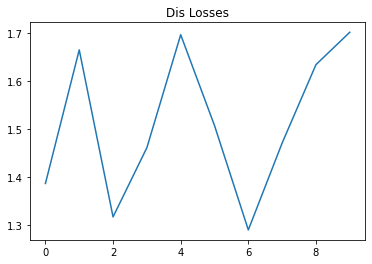

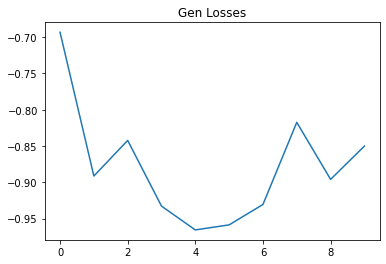

gen loss: -1.1252, dis loss: 1.5216: 100%|██████████| 100/100 [02:12<00:00,  1.33s/it]


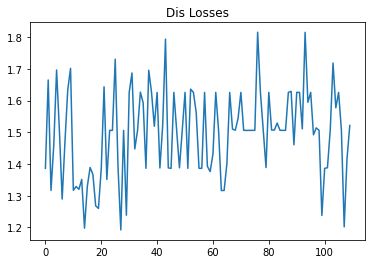

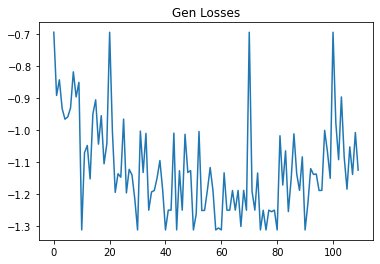

gen loss: -1.1456, dis loss: 1.3863: 100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


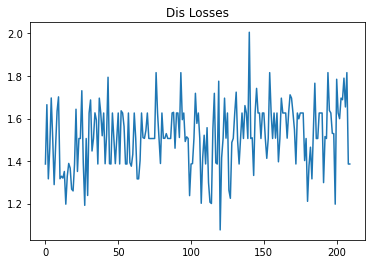

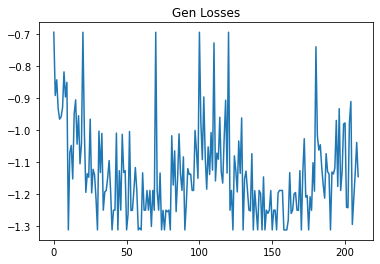

gen loss: -1.1419, dis loss: 1.3873: 100%|██████████| 100/100 [02:24<00:00,  1.44s/it]


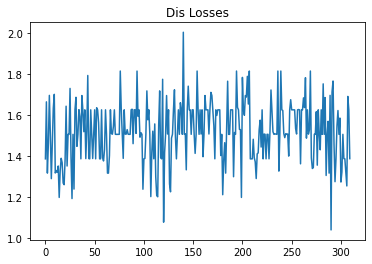

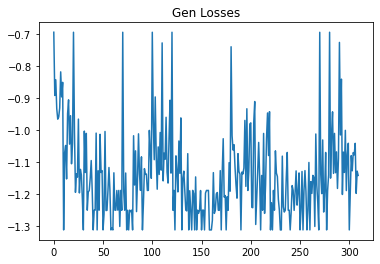

gen loss: -1.1891, dis loss: 1.3017: 100%|██████████| 100/100 [02:33<00:00,  1.54s/it]


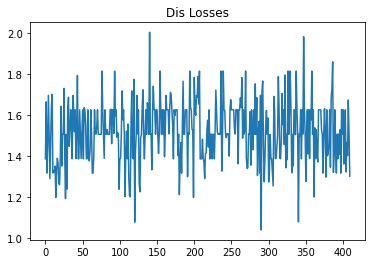

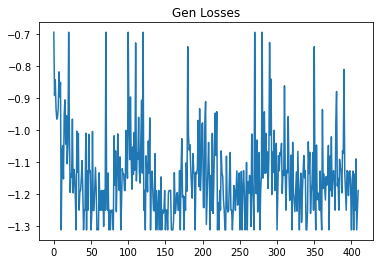

gen loss: -1.2774, dis loss: 1.5608: 100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


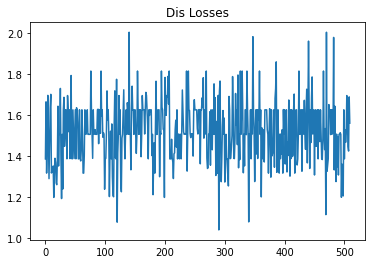

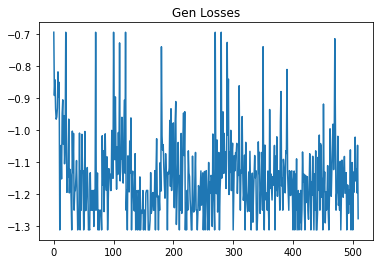

gen loss: -1.0267, dis loss: 1.4671: 100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


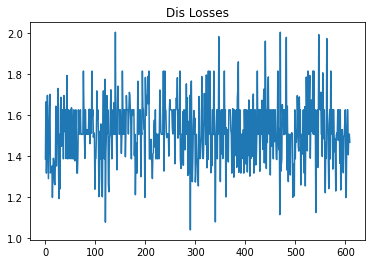

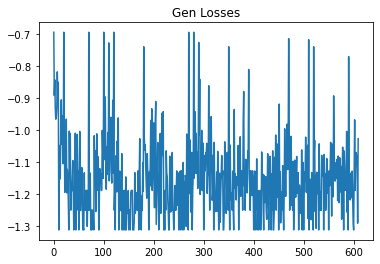

gen loss: -1.1890, dis loss: 1.6261: 100%|██████████| 100/100 [02:34<00:00,  1.55s/it]


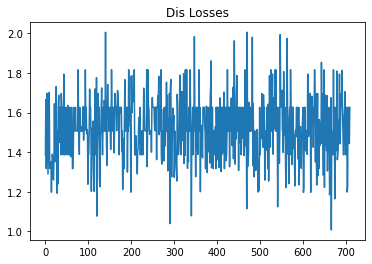

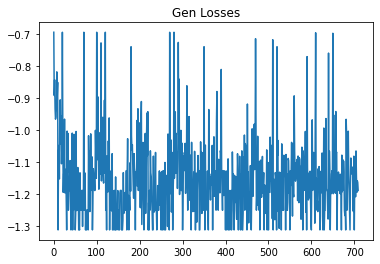

gen loss: -1.1499, dis loss: 1.7942: 100%|██████████| 100/100 [02:43<00:00,  1.63s/it]


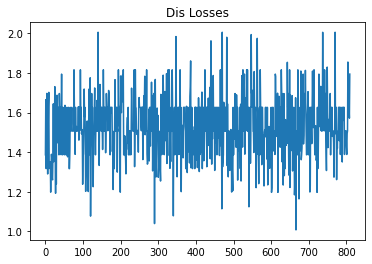

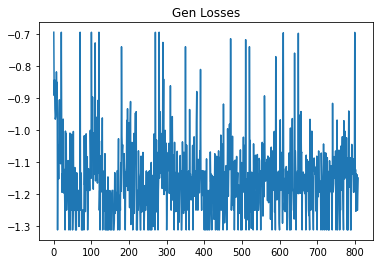

gen loss: -1.1233, dis loss: 1.5076: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


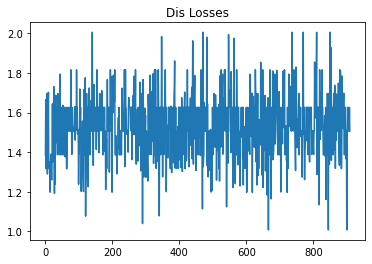

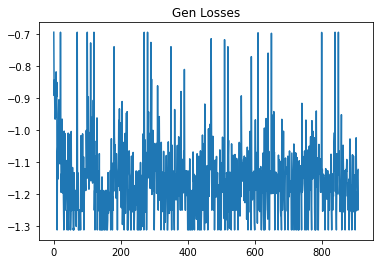

gen loss: -1.1271, dis loss: 1.6713: 100%|██████████| 100/100 [02:39<00:00,  1.60s/it]


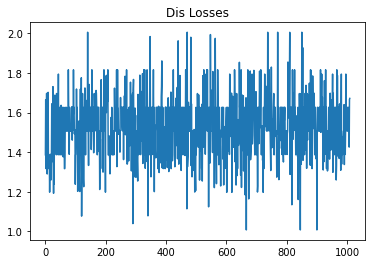

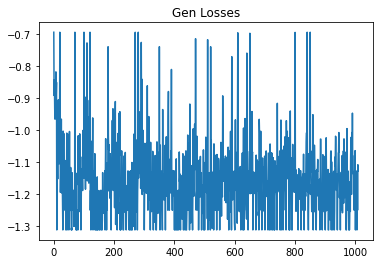

gen loss: -1.2774, dis loss: 1.6261: 100%|██████████| 100/100 [02:24<00:00,  1.44s/it]


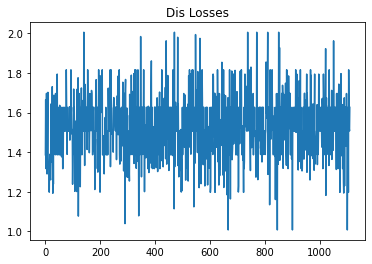

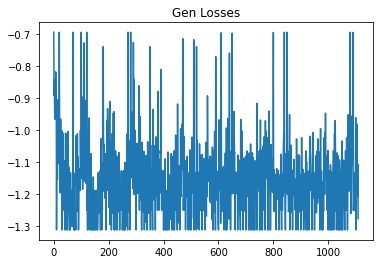

gen loss: -1.1268, dis loss: 1.4356: 100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


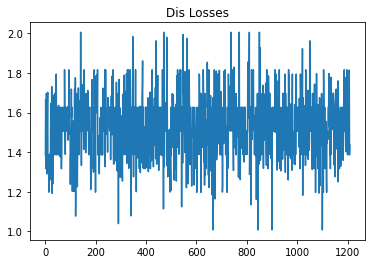

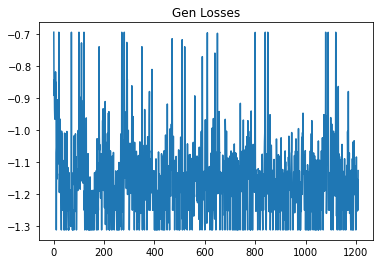

gen loss: -1.1425, dis loss: 1.5289: 100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


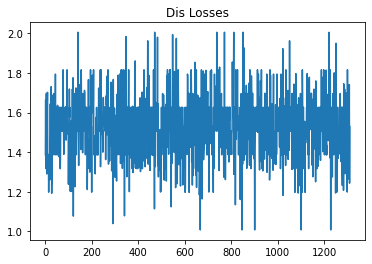

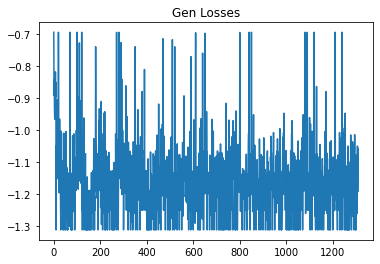

gen loss: -1.2016, dis loss: 1.3536: 100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


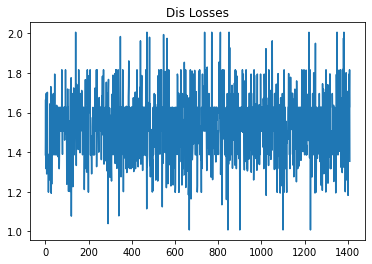

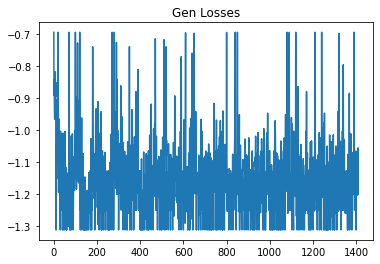

gen loss: -1.1299, dis loss: 1.6261: 100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


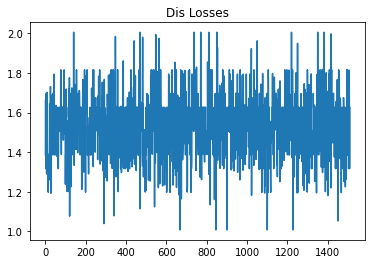

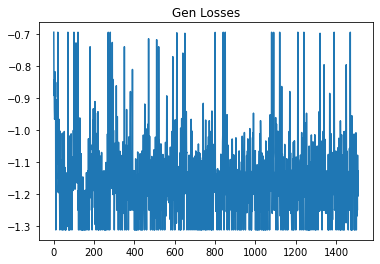

gen loss: -1.1412, dis loss: 1.5964: 100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


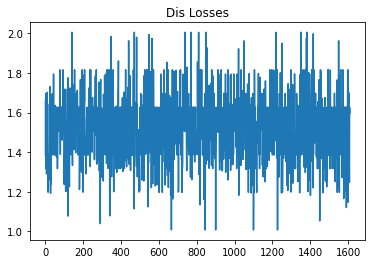

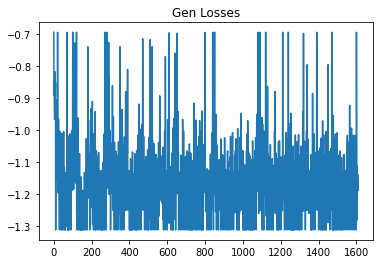

gen loss: -1.1403, dis loss: 1.4087: 100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


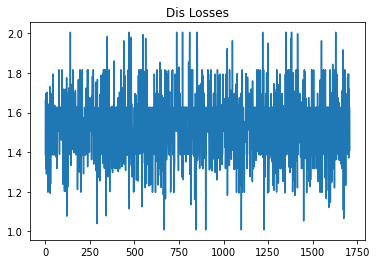

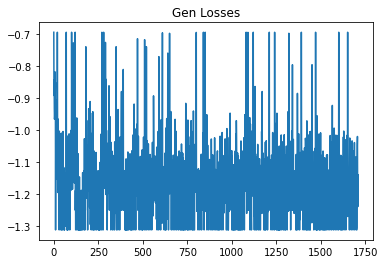

gen loss: -1.1555, dis loss: 1.4271: 100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


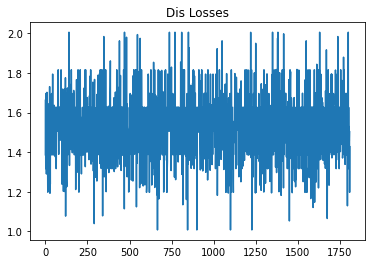

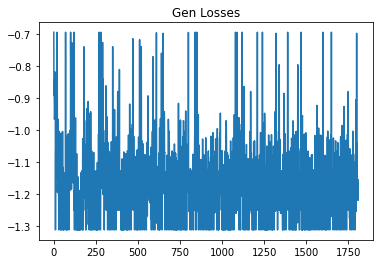

gen loss: -1.2343, dis loss: 1.6261: 100%|██████████| 100/100 [02:33<00:00,  1.53s/it]


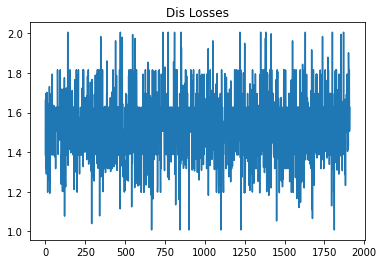

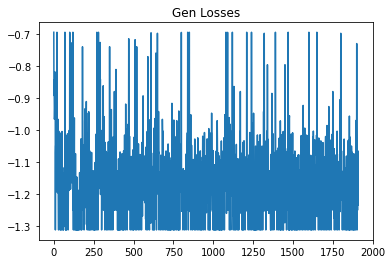

gen loss: -1.1316, dis loss: 1.3164: 100%|██████████| 100/100 [02:30<00:00,  1.51s/it]


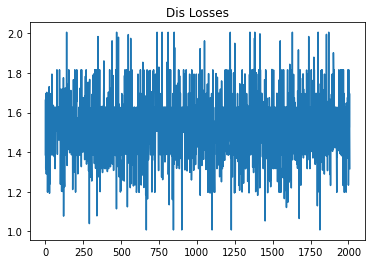

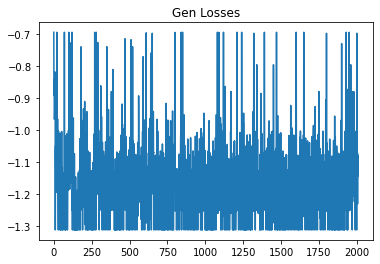

gen loss: -1.1331, dis loss: 1.5076: 100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


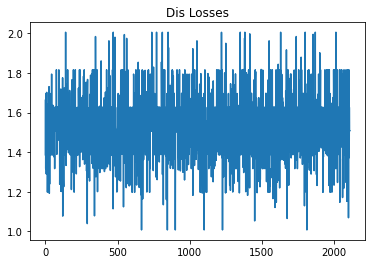

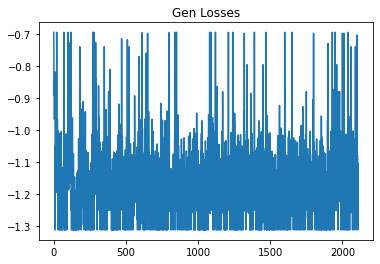

gen loss: -1.1490, dis loss: 1.5208: 100%|██████████| 100/100 [02:30<00:00,  1.51s/it]


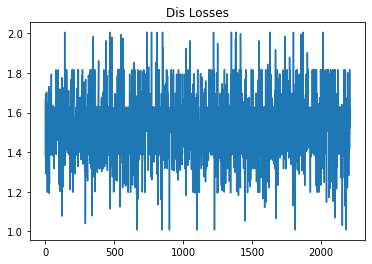

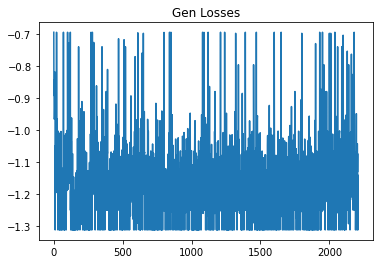

gen loss: -1.1938, dis loss: 1.8058: 100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


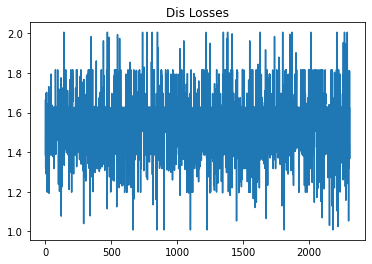

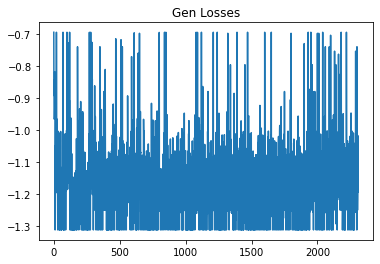

gen loss: -1.1668, dis loss: 1.5078: 100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


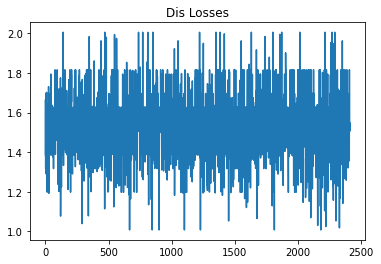

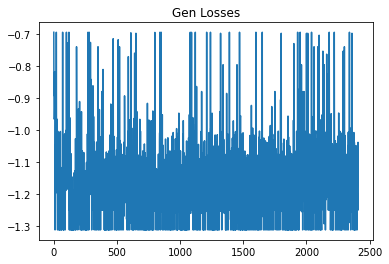

gen loss: -1.2312, dis loss: 1.6403: 100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


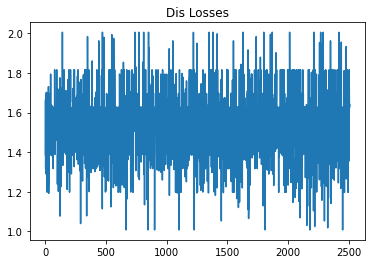

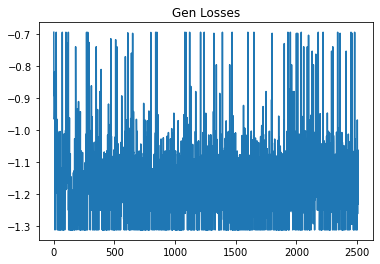

gen loss: -0.9523, dis loss: 1.6018: 100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


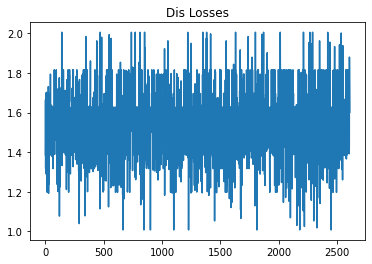

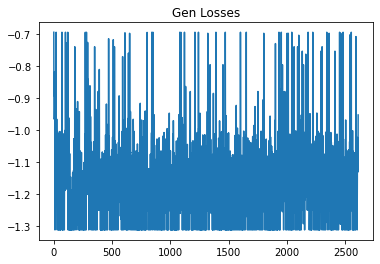

gen loss: -1.0874, dis loss: 1.3923: 100%|██████████| 100/100 [02:30<00:00,  1.51s/it]


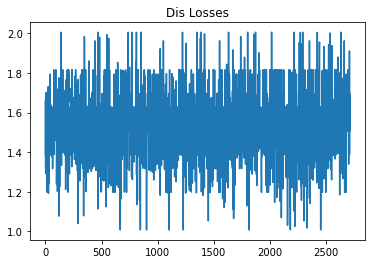

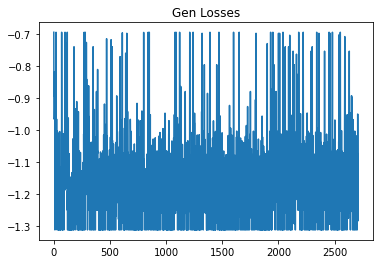

gen loss: -1.2346, dis loss: 1.7426: 100%|██████████| 100/100 [02:37<00:00,  1.57s/it]


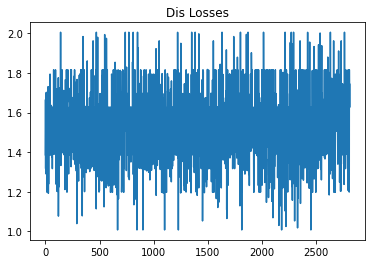

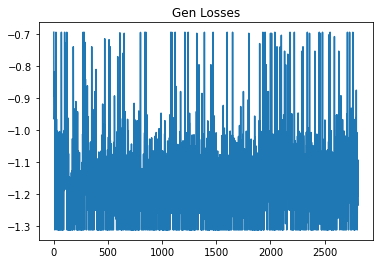

gen loss: -1.2163, dis loss: 1.6398: 100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


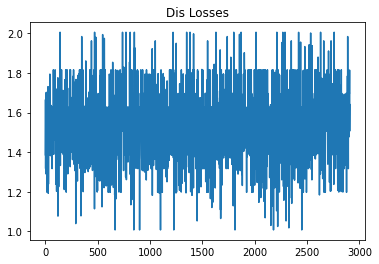

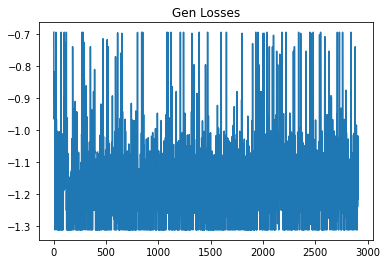

gen loss: -1.1326, dis loss: 1.5062:  29%|██▉       | 29/100 [00:45<01:36,  1.36s/it]

In [0]:
run_model()

### Second Run

Created


epoch: 1, resets: 0, gen loss: -0.8827, dis loss: 1.5993: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type t5Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type t5Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


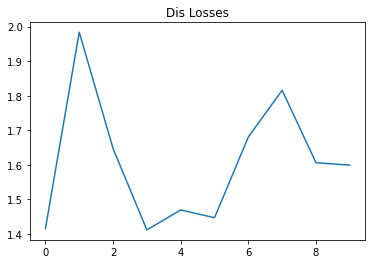

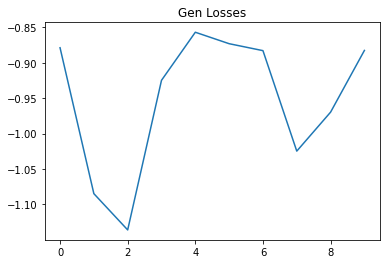

epoch: 2, resets: 0, gen loss: -0.8892, dis loss: 1.5941: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s]
epoch: 3, resets: 0, gen loss: -1.1927, dis loss: 1.6261: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]
epoch: 4, resets: 0, gen loss: -1.0090, dis loss: 1.6261: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]
epoch: 5, resets: 0, gen loss: -1.3126, dis loss: 1.6261: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]
epoch: 6, resets: 0, gen loss: -1.1274, dis loss: 1.6261: 100%|██████████| 100/100 [01:25<00:00,  1.18it/s]
epoch: 7, resets: 0, gen loss: -1.2507, dis loss: 1.6261: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]
epoch: 8, resets: 0, gen loss: -1.1911, dis loss: 1.6261: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]
epoch: 9, resets: 0, gen loss: -0.9706, dis loss: 1.3391: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s]
epoch: 10, resets: 0, gen loss: -1.0875, dis loss: 1.5062: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]
epoch: 11, resets: 0, gen l

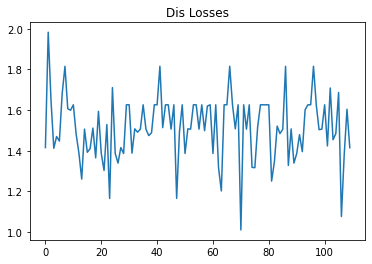

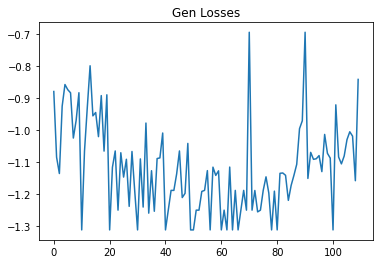

epoch: 12, resets: 0, gen loss: -1.0210, dis loss: 1.3863: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s]
epoch: 13, resets: 0, gen loss: -1.2073, dis loss: 1.6960: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]
epoch: 14, resets: 0, gen loss: -1.1463, dis loss: 1.6261: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
epoch: 15, resets: 0, gen loss: -1.3126, dis loss: 1.6261: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]
epoch: 16, resets: 0, gen loss: -1.3126, dis loss: 1.5062: 100%|██████████| 100/100 [01:24<00:00,  1.18it/s]
epoch: 17, resets: 0, gen loss: -1.2507, dis loss: 1.6261: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]
epoch: 18, resets: 0, gen loss: -1.0687, dis loss: 1.3164: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
epoch: 19, resets: 0, gen loss: -1.3126, dis loss: 1.3391: 100%|██████████| 100/100 [01:17<00:00,  1.30it/s]
epoch: 20, resets: 0, gen loss: -0.9492, dis loss: 1.5038: 100%|██████████| 100/100 [01:15<00:00,  1.33it/s]
epoch: 21, resets: 

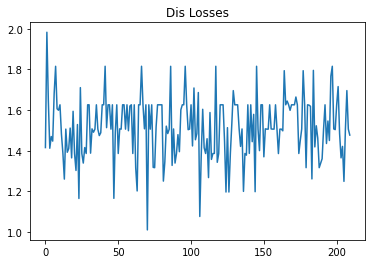

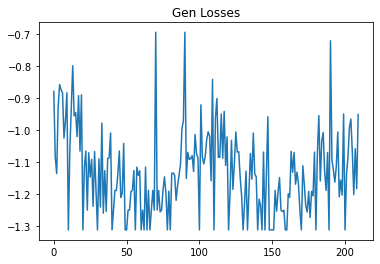

In [0]:
run_model(epochs=21)

### Third Run

with cos-annhealing learning rate scheduler

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/100 [00:00<?, ?it/s]

Created


epoch: 1, resets: 0, gen loss: -1.4451, dis loss: 1.3842: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type t5Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type t5Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


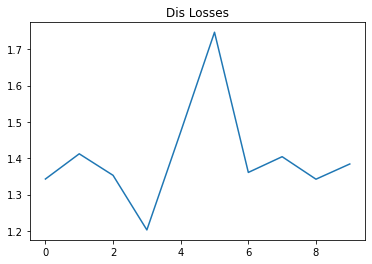

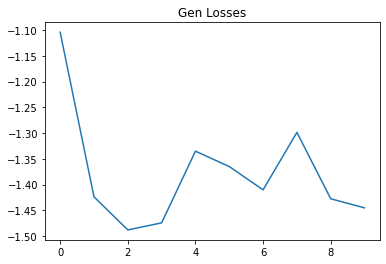

epoch: 2, resets: 0, gen loss: -1.3732, dis loss: 1.1980: 100%|██████████| 100/100 [01:28<00:00,  1.12it/s]
epoch: 3, resets: 0, gen loss: -1.4159, dis loss: 1.3892: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]
epoch: 4, resets: 0, gen loss: -1.5237, dis loss: 1.6327: 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]
epoch: 5, resets: 0, gen loss: -1.5088, dis loss: 1.7856: 100%|██████████| 100/100 [01:31<00:00,  1.10it/s]
epoch: 6, resets: 0, gen loss: -1.5518, dis loss: 1.5918: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s]
epoch: 7, resets: 0, gen loss: -1.5640, dis loss: 1.6407: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s]
epoch: 8, resets: 0, gen loss: -1.4117, dis loss: 1.5042: 100%|██████████| 100/100 [01:22<00:00,  1.22it/s]
epoch: 9, resets: 0, gen loss: -1.3874, dis loss: 2.0009: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]
epoch: 10, resets: 0, gen loss: -1.4004, dis loss: 1.1120: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]
epoch: 11, resets: 0, gen l

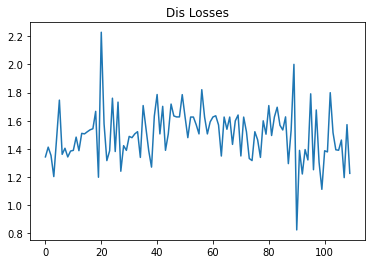

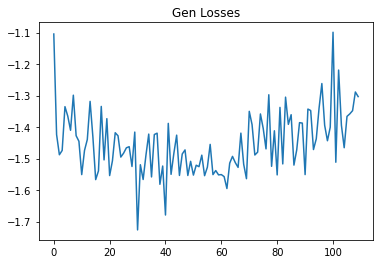

epoch: 12, resets: 0, gen loss: -1.4617, dis loss: 1.3207:  88%|████████▊ | 88/100 [01:20<00:10,  1.15it/s]

KeyboardInterrupt: ignored

In [0]:
run_model(30, savestr=root+"testing")

### 4th run

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/100 [00:00<?, ?it/s]

Created


epoch: 1, resets: 0, gen loss: -1.4108, dis loss: 1.3862: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type t5Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type t5Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


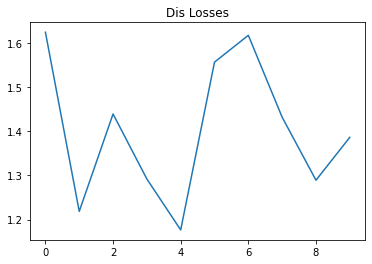

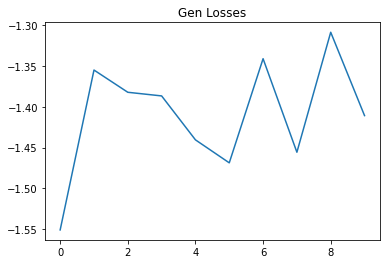

epoch: 2, resets: 0, gen loss: -1.2654, dis loss: 1.3844: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]
epoch: 3, resets: 0, gen loss: -1.4713, dis loss: 1.8159: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
epoch: 4, resets: 0, gen loss: -1.4724, dis loss: 1.7105: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s]
epoch: 5, resets: 0, gen loss: -1.5414, dis loss: 1.6260: 100%|██████████| 100/100 [01:30<00:00,  1.11it/s]
epoch: 6, resets: 0, gen loss: -1.5839, dis loss: 1.6261: 100%|██████████| 100/100 [01:29<00:00,  1.11it/s]
epoch: 7, resets: 0, gen loss: -1.4228, dis loss: 1.6261: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]
epoch: 8, resets: 0, gen loss: -1.5116, dis loss: 1.6435: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]
epoch: 9, resets: 0, gen loss: -1.2641, dis loss: 1.5097: 100%|██████████| 100/100 [01:24<00:00,  1.19it/s]
epoch: 10, resets: 0, gen loss: -1.4276, dis loss: 1.5289: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]
epoch: 11, resets: 0, gen l

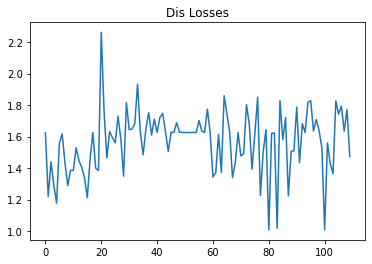

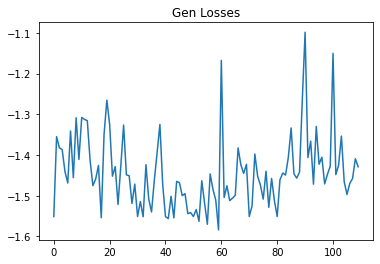

epoch: 12, resets: 0, gen loss: -1.3505, dis loss: 1.5083: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]
epoch: 13, resets: 0, gen loss: -1.4182, dis loss: 1.7522: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
epoch: 14, resets: 0, gen loss: -1.5132, dis loss: 1.5065: 100%|██████████| 100/100 [01:29<00:00,  1.12it/s]
epoch: 15, resets: 0, gen loss: -1.5172, dis loss: 1.7163: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]
epoch: 16, resets: 0, gen loss: -1.5203, dis loss: 1.5080: 100%|██████████| 100/100 [01:23<00:00,  1.19it/s]
epoch: 17, resets: 0, gen loss: -1.5106, dis loss: 1.2851: 100%|██████████| 100/100 [01:25<00:00,  1.18it/s]
epoch: 18, resets: 0, gen loss: -1.5111, dis loss: 1.5128: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]
epoch: 19, resets: 0, gen loss: -1.4761, dis loss: 1.7992: 100%|██████████| 100/100 [01:20<00:00,  1.25it/s]
epoch: 20, resets: 0, gen loss: -1.4276, dis loss: 1.6178: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


In [0]:
run_model(20, savestr=root+"testing2")

In [0]:
cb = conversation_bot(root+'testing2', dataset.encode, dataset.decode, resets=0)
cb.converse(3)

Input conversation topic:
Hello
Generating Response:
topic: Hello 1_apprentice:
topic: Hello 1_apprentice:1_apprentice:: <extra_id_0>: Hello 1_apprentice:::::::: Hello 1_apprentice::::::::::::::::::::::::::: 
Input Your Response:
I love tacos. Do you love tacos?
Generating Response:
topic: Hello 1_apprentice:: <extra_id_0>: Hello 1_apprentice:::::::: Hello 1_apprentice::::::::::::::::::::::::::: 0_wizard:: I love tacos. Do you love tacos? 1_apprentice:
topic: Hello 1_apprentice:1_apprentice:: <extra_id_0>: Hello 1_apprentice:::::::: Hello 1_apprentice::::::::::::::::::::::::::: 
Input Your Response:
Why don't you want to talk to me?
Generating Response:
topic: Hello 1_apprentice:: <extra_id_0>: Hello 1_apprentice:::::::: Hello 1_apprentice::::::::::::::::::::::::::: 0_wizard:: I love tacos. Do you love tacos? 1_apprentice:: <extra_id_0>:::::::::::::::::::::::::::::::::::::::::::::::: 0_wizard:: Why don't you want to talk to me? 1_apprentice:
topic: Hello 1_apprentice:1_apprentice:: <ex

'Thanks for chatting!'

In [0]:
dict_ = torch.load(root+"testing2_0_resets.pt")
gen = dict_['gen'].cpu()

def test_text(text):
    out = gen(dataset.encode(text))
    print(dataset.decode(out))

test_text("topic: Hello 0_wizard: Hello young one, how are you? 1_apprentice: I am good, how are you? 0_wizard: I am well thank you! What do you like to do?")
test_text("topic: Hello 0_wizard: I like cars, do you?")

<extra_id_0>d: I am well thank you! What do you like to do? 1_apprentice: I am good, how are you? 1_apprentice: I am good, how are you? 1_apprentice
I like cars, do you????? cars, do you?????? cars, do you???????? cars, do you??????? cars, do you?


### 5th run

Created


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
epoch: 1, resets: 0, gen loss: -1.3831, dis loss: 1.6261: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type t5Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retri

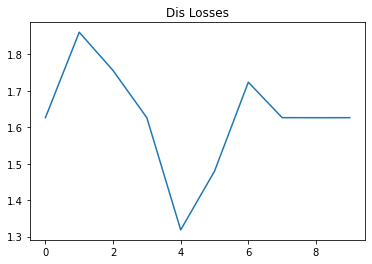

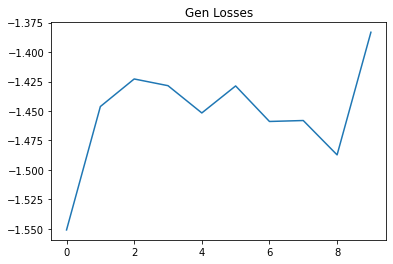

epoch: 2, resets: 0, gen loss: -1.4102, dis loss: 1.5170: 100%|██████████| 100/100 [01:24<00:00,  1.19it/s]
epoch: 3, resets: 0, gen loss: -1.4483, dis loss: 1.6261: 100%|██████████| 100/100 [01:24<00:00,  1.18it/s]
epoch: 4, resets: 0, gen loss: -1.4577, dis loss: 1.6261: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]
epoch: 5, resets: 0, gen loss: -1.5904, dis loss: 1.6364: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]
epoch: 6, resets: 0, gen loss: -1.5022, dis loss: 1.6260: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]
epoch: 7, resets: 0, gen loss: -1.4799, dis loss: 1.5339: 100%|██████████| 100/100 [01:20<00:00,  1.24it/s]
epoch: 8, resets: 0, gen loss: -1.3994, dis loss: 1.8962: 100%|██████████| 100/100 [01:23<00:00,  1.20it/s]
epoch: 9, resets: 0, gen loss: -1.4694, dis loss: 1.8320: 100%|██████████| 100/100 [01:22<00:00,  1.21it/s]
epoch: 10, resets: 0, gen loss: -1.4662, dis loss: 1.5912: 100%|██████████| 100/100 [01:24<00:00,  1.19it/s]
epoch: 11, resets: 0, gen l

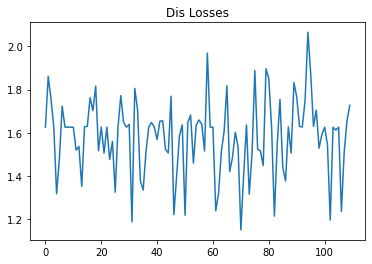

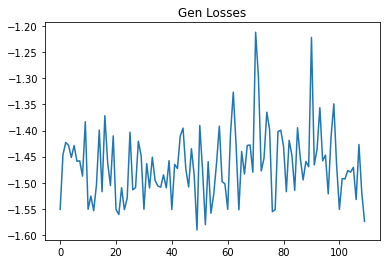

epoch: 12, resets: 0, gen loss: -1.0987, dis loss: 2.0458:  10%|█         | 10/100 [00:07<01:11,  1.25it/s]

KeyboardInterrupt: ignored

In [0]:
run_model(20, savestr=root+"testing3")

In [0]:
dict_ = torch.load(root+"testing3_0_resets.pt")
gen = dict_['gen'].cpu()

def test_text(text):
    out = gen(dataset.encode(text))
    print(dataset.decode(out))

test_text("topic: Hello 0_wizard: Hello young one, how are you?")
test_text("topic: Hello 0_wizard: I like cars, do you?")

Hello young one, how are you??????????????????????????????????????????
I like cars, do you????? cars, do you?????? cars, do you???????? cars, do you??????? cars, do you?


In [0]:
cb = conversation_bot(root+'testing3', dataset.encode, dataset.decode, resets=0)
cb.converse(2)

Input conversation topic:
Cars
Start the conversation:
hello, are you stupid?
Generating Response:
: Cars 0_wizard:: hello, are you stupid? 0_wizard:: hello, are you stupid? 1_apprenticeice: iceiceiceiceice: ice


Full convo: topic: Cars 0_wizard:: hello, are you stupid? 1_apprentice:1_apprentice:: : Cars 0_wizard:: hello, are you stupid? 0_wizard:: hello, are you stupid? 1_apprenticeice: iceiceiceiceice: ice  

Input Your Response:
stop copying me
Generating Response:
<extra_id_0>ice: ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice


Full convo: topic: Cars 0_wizard:: hello, are you stupid? 1_apprentice:: : Cars 0_wizard:: hello, are you stupid? 0_wizard:: hello, are you stupid? 1_apprenticeice: iceiceiceiceice: ice 0_wizard:: stop copying me 1_apprentice:1_apprentice:: <extra_id_0>ice: ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice ice  

Input Your Response:
whyyyyyyyyyyyyyyyy?????
Generating Respon

### 6th Run

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/100 [00:00<?, ?it/s]

Created


epoch: 1, resets: 0, gen loss: -1.3925, dis loss: 1.3617: 100%|██████████| 100/100 [00:37<00:00,  2.65it/s]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type t5Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type t5Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


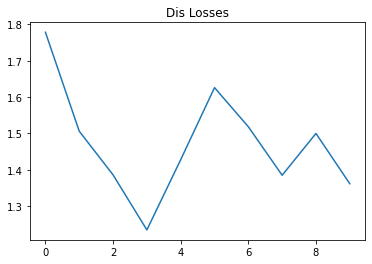

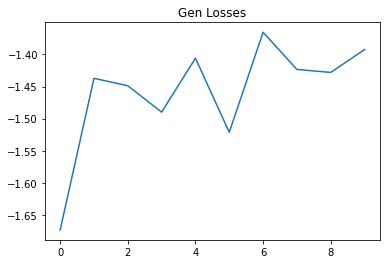

epoch: 2, resets: 0, gen loss: -1.3326, dis loss: 1.4838: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]
epoch: 3, resets: 0, gen loss: -1.5007, dis loss: 1.6269: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]
epoch: 4, resets: 0, gen loss: -1.4492, dis loss: 1.6807: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]
epoch: 5, resets: 0, gen loss: -1.4190, dis loss: 1.6263: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]
epoch: 6, resets: 0, gen loss: -1.5028, dis loss: 1.2719: 100%|██████████| 100/100 [00:40<00:00,  2.50it/s]
epoch: 7, resets: 0, gen loss: -1.4729, dis loss: 1.1191: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]
epoch: 8, resets: 0, gen loss: -1.3577, dis loss: 1.5382: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]
epoch: 9, resets: 0, gen loss: -1.5064, dis loss: 1.6808: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s]
epoch: 10, resets: 0, gen loss: -1.4556, dis loss: 1.6260: 100%|██████████| 100/100 [00:40<00:00,  2.46it/s]
epoch: 11, resets: 0, gen l

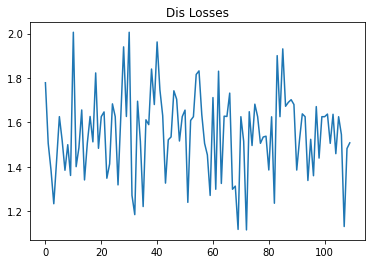

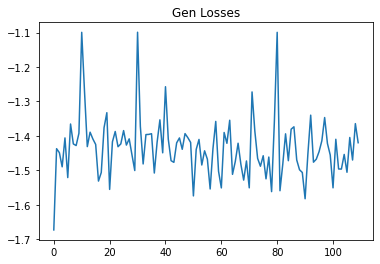

epoch: 12, resets: 0, gen loss: -1.3846, dis loss: 2.0014: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s]
epoch: 13, resets: 0, gen loss: -1.5341, dis loss: 1.9325: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]
epoch: 14, resets: 0, gen loss: -1.3871, dis loss: 1.6263: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]
epoch: 15, resets: 0, gen loss: -1.3881, dis loss: 1.4714: 100%|██████████| 100/100 [00:40<00:00,  2.50it/s]
epoch: 16, resets: 0, gen loss: -1.5286, dis loss: 1.6261: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]
epoch: 17, resets: 0, gen loss: -1.5437, dis loss: 1.6847: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]
epoch: 18, resets: 0, gen loss: -1.3915, dis loss: 1.3653: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]
epoch: 19, resets: 0, gen loss: -1.4428, dis loss: 1.6261: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s]
epoch: 20, resets: 0, gen loss: -1.4863, dis loss: 1.6273: 100%|██████████| 100/100 [00:41<00:00,  2.43it/s]
epoch: 21, resets: 

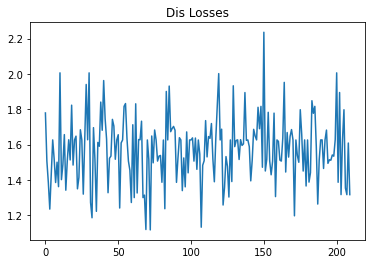

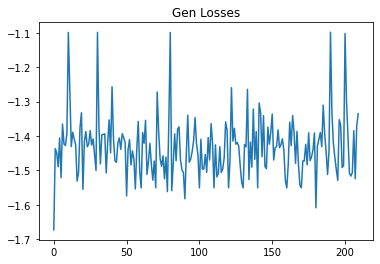

epoch: 22, resets: 0, gen loss: -1.3631, dis loss: 1.1429: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s]
epoch: 23, resets: 0, gen loss: -1.5127, dis loss: 1.7937: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]
epoch: 24, resets: 0, gen loss: -1.5252, dis loss: 1.3250: 100%|██████████| 100/100 [00:42<00:00,  2.34it/s]
epoch: 25, resets: 0, gen loss: -1.5365, dis loss: 1.5927: 100%|██████████| 100/100 [00:40<00:00,  2.49it/s]
epoch: 26, resets: 0, gen loss: -1.4613, dis loss: 1.5156: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]
epoch: 27, resets: 0, gen loss: -1.3063, dis loss: 1.5062: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]
epoch: 28, resets: 0, gen loss: -1.5145, dis loss: 1.3167: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s]
epoch: 29, resets: 0, gen loss: -1.4306, dis loss: 1.4709: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]
epoch: 30, resets: 0, gen loss: -1.4420, dis loss: 1.2276: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]


In [0]:
run_model(30, savestr=root+"testing4")

In [0]:
cb = conversation_bot(root+'testing4', dataset.encode, dataset.decode, resets=0)
cb.converse(2)

Input conversation topic:
Cars
Start the conversation:
Please tell me about your car
Generating Response:
Cars 0_wizard:: Please tell me about your your car 1


Full convo: topic: Cars 0_wizard:: Please tell me about your car 1_apprentice:1_apprentice:: Cars 0_wizard:: Please tell me about your your car 1  

Input Your Response:
I really want you to talk to me
Generating Response:
Cars 0_wizard:: Please tell me about your your car 1


Full convo: topic: Cars 0_wizard:: Please tell me about your car 1_apprentice:: Cars 0_wizard:: Please tell me about your your car 1 0_wizard:: I really want you to talk to me 1_apprentice:1_apprentice:: Cars 0_wizard:: Please tell me about your your car 1  

Input Your Response:
My car is blue, what color is yours?
Generating Response:
Cars 0_wizard:: Please tell me about your your car 1


Full convo: topic: Cars 0_wizard:: Please tell me about your car 1_apprentice:: Cars 0_wizard:: Please tell me about your your car 1 0_wizard:: I really want you to ta

### 7th Run (New Dataloader)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/111748 [00:00<?, ?it/s]

Created


epoch: 1, resets: 0, gen loss: -1.2821, dis loss: 1.5064:  90%|████████▉ | 100352/111748 [7:14:34<59:59,  3.17it/s]  Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors
epoch: 1, resets: 0, gen loss: -1.2555, dis loss: 1.7563: 100%|██████████| 111748/111748 [8:03:46<00:00,  3.85it/s]
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type t5Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type t5Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


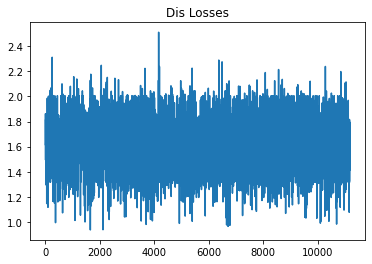

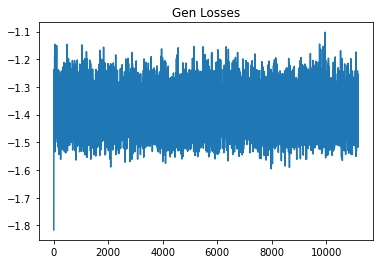

epoch: 2, resets: 0, gen loss: -1.4631, dis loss: 1.4833:  17%|█▋        | 19124/111748 [1:22:57<6:07:59,  4.20it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors
epoch: 2, resets: 0, gen loss: -1.3843, dis loss: 1.6060:  82%|████████▏ | 91242/111748 [6:36:40<1:33:11,  3.67it/s]

KeyboardInterrupt: ignored

In [0]:
dataset = WikiDataset_paired_lines()
dataloader = DataLoader(dataset, batch_size=1, shuffle=True) # TODO: fix batch size by padding
run_model(2, savestr=root+"testing5", save_skip=1)

In [0]:
dataset = WikiDataset_paired_lines()
dataloader = DataLoader(dataset, batch_size=1, shuffle=True) # TODO: fix batch size by padding
run_model(2, savestr=root+"testing5", save_skip=1)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/111748 [00:00<?, ?it/s]

Created


epoch: 1, resets: 0, gen loss: -1.4110, dis loss: 1.6720:   0%|          | 129/111748 [00:33<7:17:54,  4.25it/s]

KeyboardInterrupt: ignored

# New loss function

trying to make the generator spit out good sentences based on setnence similarity of a T5 sentence discriminator.

We are using sentence similarity now for this training method using the Pre-trained T5 for the genrator and another pre-trained T5 as the similarity loss function. (minimize negative similarity)

## Playground 3 

### New Dataset

In [4]:
class WikiDataset_paired_lines(Dataset):
    def __init__(self, root=root, max_training_epoch_length=None, tokenizer=T5Tokenizer.from_pretrained(t5_model), percent_test=.33):
        super(WikiDataset_paired_lines, self).__init__()

        self.n_times_reset = 0

        df = pd.read_pickle(root+"data/wiki.pkl").sample(frac=1)

        self.max_training_epoch_length = max_training_epoch_length     # this will allow us to set shorter epochs to introduce more randomness into the length

        # store data as arrays instead of dataframe
        self.conv_lengths = df['convo_len'].values
        self.conversations = df['convo'].values
        self.topics = df['chosen_topic'].values

        # set tokenizer
        # take a look at t5 toeknizer 
        self.tokenizer = tokenizer
        tokens = ['topic:', 'previous_line:', 'response:']
        self.tokenizer.add_tokens(tokens)
        

        self.indices = []
        for i in range(len(self.conv_lengths)):
            for j in range(self.conv_lengths[i]):
                self.indices += [(i, j)]

        np.random.shuffle(self.indices)
        split = int(np.floor(1-percent_test*len(self.indices)))
        self.training_indices, self.testing_indices = self.indices[:split], self.indices[split:]

        self.training_length = len(self.training_indices)
        self.testing_length = len(self.testing_indices)

        self.testing_mode = False
        

    def __getitem__(self, i):
        if self.testing_mode:
            (k, j) = self.testing_indices[i]
        else:
            (k, j) = self.training_indices[i]

        true_response = self.conversations[k][j]
        if j == 0:
            common_prompt = f'topic: {self.topics[k]} response: '
        else:
            common_prompt = f'topic: {self.topics[k]} previous_line: {self.conversations[k][j-1]} response: '

        if self.tokenizer:
            common_prompt = self.encode(common_prompt) 
            true_response = self.encode(true_response)

        return common_prompt.squeeze(0), true_response.squeeze(0)

    def __len__(self):
        if self.testing_mode:
            return self.testing_length
        elif self.max_training_epoch_length:
            return min(self.training_length, self.max_training_epoch_length)
        else:
            return self.training_length

    def decode(self, id_list):
        return self.tokenizer.convert_tokens_to_string(dataset.tokenizer.convert_ids_to_tokens(id_list.squeeze(0)))

    def encode(self, str):
        return torch.Tensor(self.tokenizer.encode(str)).unsqueeze(0).long()

    def set_testing_mode(self, testing_mode):
        self.testing_mode = testing_mode

In [0]:
dataset =  WikiDataset_paired_lines()

In [0]:
len(dataset)

111748

In [0]:
dataset.set_testing_mode(True)
len(dataset)

55039

In [0]:
dataloader = DataLoader(dataset)
for prompt, response in dataloader:
    print(dataset.decode(prompt))
    print()
    print(dataset.decode(response))
    break

previous_line: I know, I live in Florida too! Of course lizards can vary a lot in size from chameleons to geckos.response:

Yes, in my yard I have everything from the little common lizards, to iguanas, to basilisks! I wonder why lizards thrive in Florida? What do they eat?


### Loss Function

In [0]:
class SimLoss(nn.Module):

    def __init__(self, network=T5ForConditionalGeneration.from_pretrained(t5_model)):
        super(SimLoss, self).__init__()
        network.resize_token_embeddings(len(dataset.tokenizer))
        self.network = network

    def forward(self, y_hat, y):
        y_hat_str = dataset.decode(y_hat)
        y_str = dataset.decode(y)
        text = "stsb sentence1: " + y_hat_str + " sentence2: " + y_str
        # print(text)
        out = dataset.decode(self.network.generate(dataset.encode(text), early_stopping=True, repetition_penalty=True))
        # print("out",out, out.isnumeric())
        if out.replace('.','',1).isdigit():
            out = float(out)
        else:
            out = 0.0

        result = torch.Tensor([out])
        result.requires_grad = True
        # print("result", result)
        return -1*result

### Training

In [0]:
def new_training_loop(epochs, generator, loss_func, dataset, dataloader,
                    optimizer, scheduler,
                    gen_losses=[], dis_losses=[], savestr=root+'checkpoint',
                    gen_iters=1, dis_iters=1, plot_skip=10, save_skip=10, dis_train_skip=5):

    #initialize your generator and discriminator models
    generator = generator.cuda()

    i = 0
    losses = []
    for e in range(epochs):

        scheduler.step()

        temp_losses = []

        # initialize tqdm 
        loop = tqdm(total = len(dataloader),position=0)

        for i, (prompts, true_responses) in enumerate(dataloader):
            prompts = prompts.cuda(async=True)
            true_responses = true_responses.cuda(async=True)

            optimizer.zero_grad()

            out = generator(prompts)

            loss = loss_func(out, true_responses)
            loss.backward()
            optimizer.step()
            # print("loss", loss)

            temp_losses.append(loss.cpu().item())
            
            if i%plot_skip == 0:
                losses.append(np.mean(temp_losses))
                temp_losses = []

            loop.set_description('epoch: {}, loss: {:.4f}'.format(e+1, losses[-1]))
            loop.update(1)

            # break

        loop.close()

        if e%save_skip == 0:
            torch.save({"gen": generator, "losses": losses}, savestr+".pt")   

            plt.plot(losses)
            plt.title("Losses")
            plt.show()
        
    return generator, losses

In [0]:
# dataset = WikiDataset(max_epoch_length=100)
def new_run_model(dataset, epochs = 1, lr=.001, savestr = root+'checkpoint', plot_skip=10): 

    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    if os.path.exists(savestr):
        print("Loaded")
        dict_ = torch.load(savestr)
        gen = dict_['gen']
        losses = dict_['losses']
    else:
        print("Created")
        gen = t5Generator().cuda()
        # gen.baseModel.resize_token_embeddings(len(dataset.tokenizer))
        losses = []

    optimizer = optim.Adam(gen.parameters(), lr=lr, betas=(.9, 0.999))
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(dataloader), eta_min=lr)
    loss_func = SimLoss()
    # TODO: implement lr schedule

    new_training_loop(epochs, gen,loss_func, dataset, dataloader, 
                optimizer, scheduler, losses,
                savestr = savestr,
                gen_iters=1, dis_iters=1, plot_skip=plot_skip)
    

In [0]:
dataset = WikiDataset_paired_lines()

In [0]:
new_run_model(dataset)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/111748 [00:00<?, ?it/s]

Created


epoch: 1, loss: -1.1400:   1%|          | 723/111748 [03:48<10:09:15,  3.04it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors
epoch: 1, loss: -0.9400:   3%|▎         | 3146/111748 [16:04<8:06:02,  3.72it/s]